![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")
<div align="center">Copyright (c) 2020, MBARI</div>

* Distributed under the terms of the GPL License
* Maintainer: dcline@mbari.org
* Authors: Paul Mcgill mcgill@mbari.org, Danelle Cline dcline@mbari.org

# Calculating decimation factors in hydrophone data
Our goal is to decimate the 256 kHz hydrophone data down to 2 kHz, a factor of 128. This will require first low-pass filtering the signal to limit its bandwidth, followed by downsampling (i.e. throwing out 127 out of every 128 samples). Richard Lyons describes the process in [1], section 10.1.

Instead of decimating by a factor D of 128 in one stage, it’s more efficient to use two stages, D1 and D2, resulting in much shorter filters. The optimum factor for the first stage D1 is defined in Lyons as: 

import math
def dopt(D, F):
    return 2*D*(1-math.sqrt(D*F/(2-F)))/(2-F*(D+1))

In [2]:
dopt(128, 0.1)

37.473297335009484

We can now set D1 equal to the closest integer submultiple of D,

In [3]:
def divisorGenerator(n): 
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

In [4]:
list(divisorGenerator(128))

[1, 2, 4, 8, 16.0, 32.0, 64.0, 128.0]

which is D1=32

In [5]:
d1 = 32
d2 = int(128 / d1) 
print('d1={}\t d2={}'.format(d1,d2))  

d1=32	 d2=4


# Calculating filter parameters

Now we must find the FIR filter lengths and frequencies for each of the two stages. First define the
original sample rate.

the original sampling rate is

In [6]:
sr = 256000

For the first stage, we want to start filtering at 90% of the final 1 kHz bandwidth. Now 90% is somewhat arbitrary. We could arbitrarily start rolling off at 3600 to be fully in the stop band at 4kHz. Here, we are taking advantage of the fact that in the next stage we will be filtering again down to 1 kHz. If we start rolling off at 900 Hz to be fully in the stop band at 4kHz, the wider transition band will require a shorter (faster) filter to implement.

In [7]:
f1cut = int(0.9 * 1000) 
f1cut_rad = f1cut*2*math.pi/(sr)  

print(('{0} Hz      {1:.6} radians'.format(f1cut, f1cut_rad)))

900 Hz      0.0220893 radians


We want the stopband frequency at the Nyquist rate afer the first stage decimation.

In [8]:
f1stop = (sr/d1)/2 
f1stop

4000.0

Find the transition bandwidth of the first-stage filter in radians and Hz

In [9]:
tbw1_rad = math.pi*(f1stop - f1cut)/(sr/2)
tbw1 = (f1stop - f1cut)

print(('{0} Hz      {1:.6} radians'.format(tbw1, tbw1_rad)))

3100.0 Hz      0.0760854 radians


Find the minimum length of the Blackman filter kernel for that transition bandwidth. Use the table on
page 9 of [2].

In [10]:
m1 = math.ceil((12*math.pi)/tbw1_rad)
m1

496

For the second stage, we start filtering at the same frequency as the first stage.

In [11]:
f2cut = f1cut
f2cut_rad = f2cut*2*math.pi/(sr/d1)


print(('{0} Hz    {1:.6} radians'.format(f2cut, f2cut_rad)))

900 Hz    0.706858 radians


We want the stopband frequency at the Nyquist rate after the second stage

In [12]:
f2stop = (sr / (d1*d2))/2
f2stop

1000.0

Find the transition bandwidth of the second-stage filter in radians and Hz. Note that his filter is applied to the output of the first stage, which is 4kHz bandwidth 8kHz sampling rate.

In [13]:
tbw2_rad = math.pi*(f2stop - f2cut)/f1stop
tbw2 = (f2stop - f2cut) 
print(('{0:.6} Hz    {1:.6} radians'.format(tbw2, tbw2_rad)))

100.0 Hz    0.0785398 radians


Find the minimum length of the Blackman filter kernel for that transition bandwidth. This is from [2].

In [14]:
m2 = math.ceil(12*math.pi/tbw2_rad)
m2

480

In [15]:
print('decimation \t\t kernel length\tcutoff (radians)\t\t transition bandwidth (radians)') 
print('d1={} \t\t m1={} \t\t fc1={:.6} \t\t tbw1={:.6}'.format(d1,m1,f1cut_rad,tbw1_rad))
print('d2={} \t\t m2={} \t\t fc2={:.6} \t\t tbw2={:.6}'.format(d2,m2,f2cut_rad,tbw2_rad)) 

decimation 		 kernel length	cutoff (radians)		 transition bandwidth (radians)
d1=32 		 m1=496 		 fc1=0.0220893 		 tbw1=0.0760854
d2=4 		 m2=480 		 fc2=0.706858 		 tbw2=0.0785398


# Calculating filter kernels

Now design filter kernels for the two stages of decimation. We want to use windowed sinc low-pass
filters because they’re very stable, linear-phase, and easy to calculate. Steven Smith
describes the filter design process in [3], chapter 16. We’ll use a Blackman window, which has linear
phase, 0.02 % ripple in the passband, and provides 74 dB of attenuation in the stopband. The filter
cutoff frequency ω is specified to be between 0 and Pi representing 0 Hz to the Nyquist frequency. The
length of the kernel produced is m+1 elements

Let's define a few functions to compute the windowed sync filter plot the response

In [16]:
#  make sure the plots are printed inline.
%matplotlib inline

In [17]:
def windowedSincFilterKernel(fc, N):
  '''
  The sinc function, or"sine cardinal", See  http://mathworld.wolfram.com/SincFunction.html for more info 
  :param fc: # Cutoff frequency as a fraction of the sampling rate in the range (0, 0.5)
  :param N: # Filter length
  :return: 
  '''
  import numpy as np 
  if not N % 2: N += 1  # Make sure that N is odd.
  n = np.arange(N)
   
  # Compute sinc filter.
  h = np.sinc(2 * fc * (n - (N - 1) / 2.))
   
  # Compute Blackman window.
  #w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) +   0.08 * np.cos(4 * np.pi * n / (N - 1))
  w =  np.blackman(N) # numpy equivalent is fine too
  # Multiply sinc filter with window.
  h = h * w
   
  # Normalize to get unity gain.
  h = h / np.sum(h)
  
  return h


In [18]:
def plot_response(title, stop_freq, h, max_freq, min_amplitude, sr):
  from pydsm.ft import dtft   
  import numpy as np
  import matplotlib.pyplot as plt
  Xf = dtft(h,sr) # sr = sampling frequency for the input vector h
  fig = plt.figure()
  plt.title(title) 
  f = np.arange(0, stop_freq, 1)
  b = []
  for i in f: 
    b.append(Xf(i)) 
  b_real = np.abs(b)
  plt.plot(f, 20 * np.log10(b_real), 'b', linewidth=2)
  plt.ylabel('Amplitude [dB]', color='b')
  plt.xlabel('Frequency [Hz]')
  plt.ylim(min_amplitude,0)
  plt.xlim(0,max_freq)
  plt.grid() 
  plt.show()

In [19]:
print('f1cut={0}   f1stop={1}   m1={2}'.format(f1cut, f1stop, m1))

f1cut=900   f1stop=4000.0   m1=496


In [20]:
h1 = windowedSincFilterKernel(f1cut/sr, m1) 


# Show filter stage 1 response

Here we should see at least 74 dB in attenuation at the 4000 Hz stop band, which is the maximum attenuation of the Blackman window.

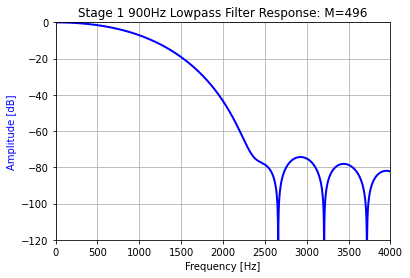

In [21]:
plot_response('Stage 1 {0}Hz Lowpass Filter Response: M={1}'.format(f1cut, len(h1) - 1), f1stop, h1, f1stop, -120, sr)

Let's take a closer look at the roll off near the final passband of 1000 Hz

In [22]:
plot_response('Stage 1 {0}Hz Low-pass Filter Response: M={1}'.format(f1cut, len(h1) - 1),f1stop, h1, 1000., -10, sr)

We're about 5 dB down at 850 Hz, which is a bit too much. We can raise the cutoff frequency in the filter as long as we still have at least 75 dB of attenuation at 4 kHz.

In [23]:
f1cut = 2000 
h1 = windowedSincFilterKernel(f1cut/sr, m1)
print(m1)

496


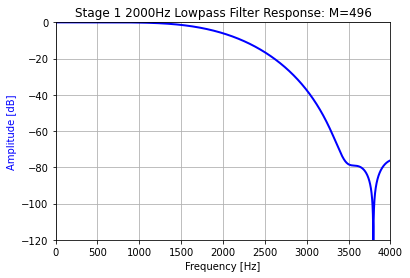

In [24]:
plot_response('Stage 1 {0}Hz Lowpass Filter Response: M={1}'.format(f1cut, len(h1) - 1), f1stop, h1, f1stop, -120, sr)

In [25]:
plot_response('Stage 1 {0}Hz Low-pass Filter Response: M={1}'.format(f1cut, len(h1) - 1),f1stop, h1, 1000., -1, sr)

Now we have very little attenuation anywhere in the final passband. This means we probably could’ve
used a shorter FIR filter but we’ll leave it as is for now.

# Show filter stage 2 response

In [26]:
print('f2cut={0}   f2stop={1}   m2={2}'.format(f2cut, f2stop, m2))

f2cut=900   f2stop=1000.0   m2=480


In [27]:
h2 = windowedSincFilterKernel(f2cut/(sr/d1), m2)
print(sr/d1)
print(f2cut)

8000.0
900


In [28]:
plot_response('Stage 2 {0}Hz Low-pass Filter Response M={1}'.format(f2cut, len(h2) - 1), f1cut, h2, f2stop, -120, sr/d1)

Once again we'll zoom into the upper potion of the graph to verify that there's not too much attenuation in the passband

In [29]:
plot_response('Stage 2 {0}Hz Lowpass Filter Response M={1}'.format(f2cut, len(h2) - 1), f1cut, h2, f2stop, -10, sr/d1)

# Filtering hydrophone data

Read in the test file (note that this is the second minute from the MARS file MARS_20171003_20002.wav)

In [30]:
import os
import soundfile as sf
file = os.path.join('test.wav')
f = sf.SoundFile(file, 'r')
info = sf.info(file)
samples = f.read()

Define a few simple functions for plotting the power spectral density (PSD) and spectrogram

In [31]:
def plot_psd(samples, num_fft, sr, ax, xmax, title='Power Spectral Density'):
  '''  
  A simply function to plot the power spectral density
  :param samples: array to generate spectrogram of
  :param num_fft: number of ffts
  :param sr: sample rate
  :param ax: axis to plot on
  :param title: optional title
  :return: 
  '''
  import matplotlib as mlab
  import scipy.signal as signal
  ax.psd(samples, NFFT=num_fft, window=signal.boxcar(num_fft), 
         Fs=int(sr), scale_by_freq=False)   
  ax.set_xlabel('Frequency [Hz]') 
  ax.set_ylabel('Amplitude [dB/Hz]', color='b') 
  ax.set_xlim(0, xmax)
  ax.set_ylim(-160, -50)
  ax.set_title(title) 

In [32]:
def plot_spec(samples, num_fft, overlap, sr, ax=None, title=''): 
  '''
   Simple function to plot spectrogram
  :param samples: array to generate spectrogram of
  :param num_fft: number of ffts
  :param overlap: overlap in samples
  :param sr: sample rate
  :param ax: axis to plot on
  :param title: optional title
  :return: 
  '''
  import matplotlib.mlab as mlab
  import numpy as np
  Pxx, freqs, bins = mlab.specgram(samples, 
                                   NFFT=num_fft, 
                                   Fs=sr, 
                                   noverlap=overlap)     
  # plot the spectrogram in dB
  Pxx_dB = np.log10(Pxx)
  ims = np.flipud(Pxx_dB)   
  ex1 = bins[0], bins[-1], freqs[0], freqs[-1]  
  ax.imshow(ims, extent=ex1) 
  ax.axis('auto')
  scale = 1/sr 
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequency (Hz)')
  ax.set_title(title)  

Here we see energy in the full frequency range of the hydrophone recording. Filtering should remove all frequencies above about 900 Hz. Note that the attenuation of frequencies above 100 kHz is due to antialiasing filter in the hydrophone

In [33]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]
f, (ax1, ax2) = plt.subplots(1, 2)
num_fft=1024
overlap=512
plot_psd(samples, num_fft, sr, ax1, int(sr/2), 'PSD raw sound')  
plot_spec(samples, num_fft, overlap, sr, ax2, 'Spectrogram raw sound')
plt.show() 

# Efficient FIR filtering for Decimation

## Overlap add method

As with any digital filtering operation, the effects at the beginning and end of each file must be considered. To process long, continuous segments of data in multiple files, the overlap-add method should be used to ensure that no data are lost at the beginning and end of each file. A description of overlap-add can be found in [3], chapter 18.   

Additionally, since we are decimating by a factor of 32, it is much more efficient to calculate only every 32nd output value, which is possible because FIR filters don't depend on past filter outputs.

In [34]:
def overlap_add_decimate(x, h, dec_factor):      
  from scipy.signal import lfilter
  import numpy as np
  target_len = int(np.ceil(len(x)/dec_factor)) + 1
  h_end = len(h)
  x_end = len(x) 
  final = np.zeros(target_len)
  for i in range(0,dec_factor):  
    pi = h[i:h_end:dec_factor] 
    if i > 0:
      xi = np.pad(x[dec_factor-i:x_end:dec_factor], (1,0), 'constant') 
      fi = np.array(lfilter(pi,[1.0],xi))
    else: 
      xi = np.pad(x[dec_factor-i:x_end:dec_factor], (1,0), 'constant', 
                  constant_values=x[0])
      fi = np.array(lfilter(pi,[1.0],xi))
    if len(fi) < target_len:
      fi = np.pad(fi, (0,1), 'constant')
    final += fi 
  return final[0:target_len-1]
  

## Slow decimation
The slow way to decimate is first to filter, then downsample. Here we downsample by the decimation factor using the python stride third argument

In [35]:
def slow_decimate(x, h, dec_factor):
  '''
  Slow decimation function
  :param x: array to decimate
  :param h: filter array
  :param dec_factor: decimation factor (integer) 
  :return: 
  '''
  from scipy.signal import lfilter
  y=lfilter(h,[1.0],x)  
  y_dec=y[0:len(x):dec_factor]
  return y_dec

# Compare decimation results and runtime

Let's gather some metrics to compare the speed of the two methods. 

In [36]:
import timeit
# override template to display time and return value
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""
# utility function to wrap arguments
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def downsample_plot(samples, NFFT, sr, h, d, title, ax1, ax2, xmax): 
  slow_wrapped = wrapper(slow_decimate, samples, h, d)
  fast_wrapped = wrapper(overlap_add_decimate, samples, h, d)
  # measure once
  fslow_time, fslow_result = timeit.timeit(slow_wrapped, number=1)  
  ffast_time, ffast_result = timeit.timeit(fast_wrapped, number=1) 
  # plot with the times
  plot_psd(fslow_result, NFFT, sr, ax1, xmax, 
           'Slow {0} {1:.5} seconds'.format(title, fslow_time)) 
  plot_psd(ffast_result, NFFT, sr, ax2, xmax, 
           'Fast {0} {1:.5} seconds'.format(title, ffast_time))   
  return ffast_result


Here we filter and downsample the data, with the first stage producing 8kHz data and the second stage producing 2kHz data. The input to the second stage is the output of the faster decimation method, which is identical to the slow method, only faster.  

Here we see that they produce the same results in the first stage and second stage, but the fast decimation is faster 

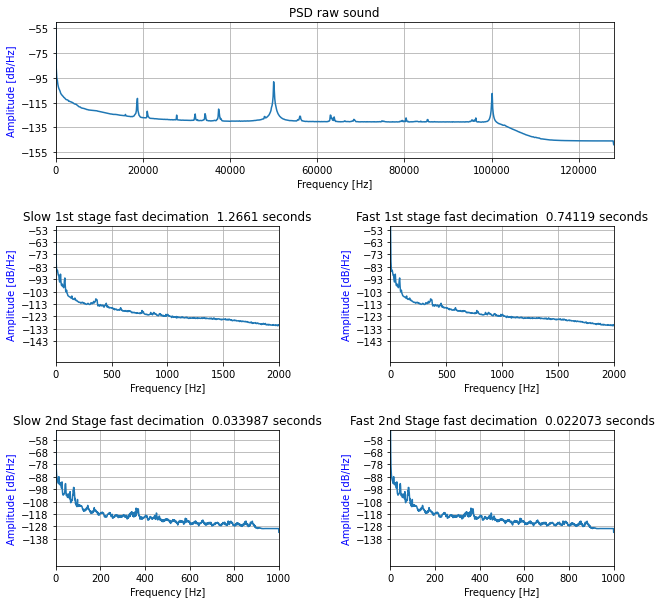

In [37]:
plt.rcParams['figure.figsize'] = [10, 10]
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0))
ax3 = plt.subplot2grid((3, 2), (1, 1))
ax4 = plt.subplot2grid((3, 2), (2, 0))
ax5 = plt.subplot2grid((3, 2), (2, 1))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plot_psd(samples, 2048, sr, ax1, int(sr/2), 'PSD raw sound')
downsampled = downsample_plot(samples, 2048, sr/d1, h1, d1, 
                              '1st stage fast decimation ', ax2, ax3, 2000) 
downsample_plot(downsampled, 2048, sr/(d1*d2), h2, d2, 
                '2nd Stage fast decimation ', ax4, ax5, 1000) 
plt.show() 

# Verify the results

The downsampled data clearly show the whale calls and the attenuation above 900 Hz, but how do we know that the low-pass filters are propertly preventing aliasing from strong signals just above the passband ?

Let's add in a strong 1200 Hz tone, just above the 900 Hz passband to see if it aliases into the data.  

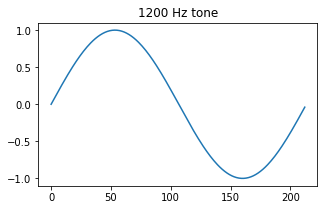

In [38]:
# This tone file was created with sox with the command: sox -n tone1200Hz.wav rate 256k synth 60 sin 1200 
file = os.path.join('tone1200Hz.wav')
f = sf.SoundFile(file, 'r')
info = sf.info(file)
tone = f.read()
plt.rcParams['figure.figsize'] = [5, 3]
plt.plot(tone[0:213])                                 
plt.title('1200 Hz tone')
plt.show()

Attenuate the tone and add it to the whale data

In [39]:
tone *= 0.001
whaletone = samples + tone

Look at the spectrum of the combined signals

In [40]:
plt.rcParams['figure.figsize'] = [10, 10]
f, (ax1, ax2) = plt.subplots(2,1,sharex=True) 
num_fft=int(len(samples)/4)
plot_psd(samples, num_fft, sr, ax1, 2000, 'PSD raw whale sound')  
plot_psd(whaletone, num_fft, sr, ax2, 2000, 'PSD raw whale sound + 1200 Hz tone')

Do the same decimation on the data containing the tone.  The 1200 Hz tone should be gone and the lower frequency whale calls should be retained.

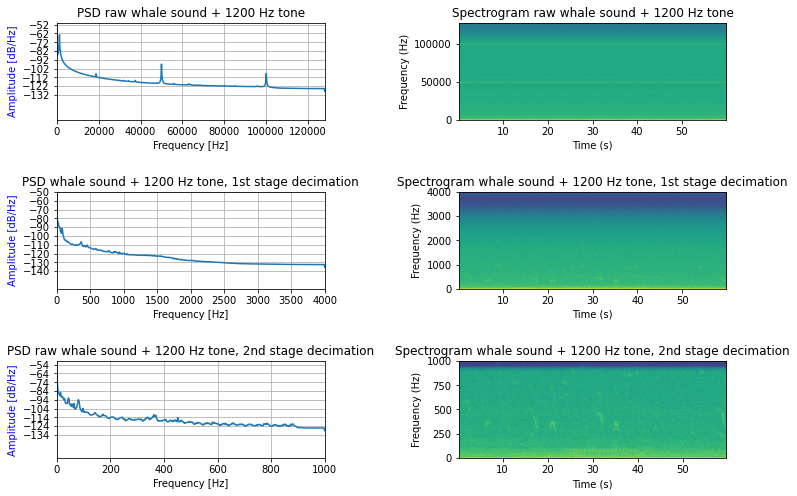

In [41]:
plt.rcParams['figure.figsize'] = [12, 8]
f, axes = plt.subplots(3, 2) 
file = os.path.join('test.wav')
f = sf.SoundFile(file, 'r')
info = sf.info(file)
samples = f.read()
s1 = overlap_add_decimate(samples, h1, d1)
s2 = overlap_add_decimate(s1, h2, d2)

num_fft = 1024 
overlap = 512
plot_psd(whaletone, num_fft, sr, axes[0,0],int(sr/2),'PSD raw whale sound + 1200 Hz tone')   
plot_spec(samples, num_fft, overlap, sr, axes[0,1], 'Spectrogram raw whale sound + 1200 Hz tone')
  
sample_rate = int(sr/(d1)) 
plot_psd(s1, num_fft, sample_rate, axes[1,0], int(sample_rate/2), 
         'PSD whale sound + 1200 Hz tone, 1st stage decimation') 
plot_spec(s1, num_fft, overlap, sample_rate, axes[1,1], 
          'Spectrogram whale sound + 1200 Hz tone, 1st stage decimation') 
    
sample_rate = int(sr/(d1*d2))
plot_psd(s2, num_fft, sample_rate,  axes[2,0],int(sample_rate/2),
         'PSD raw whale sound + 1200 Hz tone, 2nd stage decimation') 
plot_spec(s2, num_fft, overlap, sample_rate, axes[2,1], 
          'Spectrogram whale sound + 1200 Hz tone, 2nd stage decimation') 

plt.subplots_adjust(hspace=0.75, wspace=0.5)


# References
[1] Lyons, R. G. (2004). Understanding digital signal processing (2nd ed.). Upper Saddle River, NJ: Prentice
Hall.

[2] Notes on FIR filter design using window functions. (n.d.). Retrieved March 6, 2018, from https://www.ece.cmu.edu/~ece396/lectures/L19/WindowFIRDesign.pdf

[3] Smith, S. W. (1997). The scientist and engineers guide to digital signal processing. San Diego
(California): California Technical Publishing. (accessible for free at http://www.dspguide.com/pdfbook.htm)

[4] How to Create a Simple Low-Pass Filter. (n.d.). Retrieved March 06, 2018, from https://tomroelandts.-
com/articles/how-to-create-a-simple-low-pass-filter

# Questions or comments 
* Paul McGill mcgill@mbari.org
* Danelle Cline dcline@mbari.org